In [1]:
%matplotlib inline

# Robustness and Evolvability

## RNA string
Let an RNA strand be modeled as $T$ a string, with alphabet $A = \{ A, U, C, G\}$, such that $T_i$ is the $i$-th letter and let $|T| = N$ be the size of $S$.
Two nucleic acid polymers of a single RNA string can undergo basepairing interactions through hydrogen bonds (A with U and C with G)
These interactions lead the RNA single stranded string to form intricate 2D and 3D structures, and often the secondary and tertiary structures allow the RNA strand to achieve a specific function (its phenotype).
Let the RNA secondary structure be denoted as $S$.

Different algorithms have been proposed so far, to find a set of pairs $S$ that maximizes the free energy of the RNA string (objective function). 
In this work we will use the well-known [Vienna algorithm](https://www.researchgate.net/publication/51828551_ViennaRNA_package_20) to infer the secondary structure of an RNA string.
Moreover, the similarity between two strings is assessed here using distance measures such as the Levenshtein distance.



A neutral network is a set of genes all  that have equivalent function or fitness.[1] Each node represents a gene sequence and each line represents the mutation connecting two sequences. Neutral networks can be thought of as high, flat plateaus in a fitness landscape. During neutral evolution, genes can randomly move through neutral networks and traverse regions of sequence space which may have consequences for robustness and evolvability.

Interestingly, two RNA strings that are very similar (related by point mutations) are likely to have equivalent functions (secondary structures/MFE) and thus replacing one string by the other would not imply a penalty in terms of fitness: the system is __robust__ to point mutations.
Let us model be the set of RNA strings as $V$ a set of nodes, and let us consider that $E$ is a set of edges, such that  $E \subseteq V^2$, and for all $e = {v_i, v_j}\in E$, $dist(v_i,v_j)=1)$ where $dist$ denotes the Levenshtein distance between strings $v_i$ and $v_j$, then $G=\rangle V,E\langle$ is a graph of "genotypes" (or RNA strings) and an induced subgraph containing all the nodes leading to the same phenotype would be a [neutral network](https://www.wikiwand.com/en/Neutral_network_(evolution)).
In this practical work we will study the importance of [neutral networks](https://www.wikiwand.com/en/Neutral_network_(evolution)) on living organisms' evolvability, taking RNAs and their secondary structures as case study, as in [Wagner 2007](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2562401/).


__Questions:__
+ Program a mutation function that takes a sequence as an input, and apply one of the following mutations:
    + substitution: pick one random nucleotide and substitute it
    + deletion: pick one random nucleotide and  delete it
    + insertion: pick one random nucleotide and insert a new random nucleotide next to it

Let us assume that each nucleotide has the same probability to be chosen. The function should also receive the probabilities to undergo each kind of mutation.


+ Use the ViennaRNA python package (`import RNA`) to compute the secondary structures of the sequences loaded in the previous section.
    + Use the `fc = RNA.fold_compound(seq)` function to create an RNA fold object for sequence `seq`
    + Then use the `fc.mfe()` method to find the secondary structure that optimizes the Minimal Free Energy (MFE). This methods returns a tuple containing the structure the MFE itself.
    + Take a look at the structure, how are the bonds represented?

The secondary structure is represented as a string, therefore the Levenshtein distance can be used to compare the secondary structures of the RNA strings as in the previous section.

+ Write a function to load the RNA secondary structure as a `NetworkX` graph, and make another function to plot it (hint: use the `nx.kamada_kawai_layout` function to define a suitable layout). Are such graphs planar?
+ Write a function that explores the RNA sequence space as well as the corresponding secondary structure space, starting from a single ancestral sequence $T$. The exploration should run for a given number of iterations (set as a parameter), and at each iteration:

    + Generate a mutant $T' \leftarrow Mutate(T)$
    + Compute secondary structure $S'$ (here $S'$ is a string)
    + The Levenshtein distance $d(T',T)$ between the new sequence and the ancestral one is computed
    + The Levenshtein distance $d(S',S)$ between the new RNA's secondary structure and the ancestral's one is computed
    + The MFE difference w.r.t. to the ancestral MFE is computed
    + If the distance in terms of phenotype is lower than $\tau$, then we assume that this new instance belongs to the "neutral network" of the ancestral string:
        + Store the computed values (as well as the sequences) in a "neutral network" list
        + If you want to explore the neutral network, then update: $T' \leftarrow Mutate(T)$
    + Otherwise the instance does not belongs to the neutral network.
        + Store the computed values (as well as the sequences)  in a "neighborhood" list

+ Pick one sequence from the miRNA database, explore only the chosen string's neighborhood:
    + Run the code for $1\times 10^5$ iterations, how many sequences fall in the neutral network?
    + How many kinds of "phenotypes" can you reach from the ancestral sequence?
    + Represent the neighborhood and the neutral network of the ancestral string (hint: check the `motifs` submodule of `BioPython`)
    + Plot the neutral network and the neighborhood MFE and structure distance histograms
    + Represent some secondary structures as graphs
+ Run the same study but now allowing jumps in the neutral network
+ What do you notice? Conclude
+ Another important element is the MFE, add a constraint on the MFE to define the neutral network, and run the study again.

In [2]:
import RNA
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd 
from Levenshtein import distance
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

In [3]:
def generate_random_RNA_sequence(length=20, alphabet=["a","u","c","g"]):
    seq = list(np.random.choice(size=length,a=alphabet,replace=True))
    return "".join(seq)

def mutate(sequence,p=np.asarray([0,0,1])):
    alphabet = ["A","C","G","U"]
    mutations = ["insertion","deletion","substitution"]
    p = p/p.sum()
    mutation = np.random.choice(a=mutations,size=1,p=p)[0]
    location = np.random.randint(low=0,high=len(sequence),size=1)[0]
    #print(location,mutation)
    if mutation == "deletion":
        return sequence[:location]+sequence[location+1:]
    elif mutation == "insertion":
        return sequence[:location]+np.random.choice(a=alphabet,size=1)[0]+sequence[location:]
    elif mutation == "substitution":
        alphabet_new = list(set(alphabet).difference([sequence[location]]))
        return sequence[:location]+np.random.choice(a=alphabet_new,size=1)[0]+sequence[location+1:]

In [4]:
def rnasecstruc_2_graph(rna,struct):
    nodes = list(rna)
    G = nx.Graph()
    for i in range(1,len(rna)):
        G.add_edge(rna[i-1]+"|"+str(i-1),rna[i]+"|"+str(i))
    open_link = []
    for i in range(len(rna)):
        if struct[i] == "(":
            open_link.append(rna[i]+"|"+str(i))
        elif struct[i] == ")":
            last_open = open_link.pop()
            G.add_edge(last_open,rna[i]+"|"+str(i))
        else:
            pass
    return G

def plot_secondary_structure(G):
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G,pos=pos,with_labels=True,font_size=10,node_size=70,alpha=0.5)


In [5]:
def explore_space(ancestor_rna,generations,allow_neutral_network=True):
    fc = RNA.fold_compound(ancestor_rna)
    ancestor_mfe_struct, ancestor_mfe = fc.mfe()
    neutral_network = {}
    neutral_network["struct"] = [ancestor_mfe_struct]
    neutral_network["rna"] = [ancestor_rna]
    neutral_network["rna_distance"] = [0]
    neutral_network["struct_distance"] = [0]
    neutral_network["mfes"] = [ancestor_mfe]
    neutral_network["generations"] = [-1]

    neighborhood = {}
    neighborhood["struct"] = []
    neighborhood["rna"] = []
    neighborhood["rna_distance"] = []
    neighborhood["struct_distance"] = []
    neighborhood["mfes"] = []
    neighborhood["generations"] = []

    rna = ancestor_rna
    for i in tqdm(range(generations)): 
        rna_ = mutate(rna)
        fc = RNA.fold_compound(rna_)
        (mfe_struct, mfe) = fc.mfe()
        phenotype_distance = distance(ancestor_mfe_struct, mfe_struct)
        genotype_distance = distance(ancestor_rna, rna_)
        if phenotype_distance < 1  :
            neutral_network["rna"].append(rna_)
            neutral_network["struct"].append(mfe_struct)
            neutral_network["rna_distance"].append(genotype_distance)
            neutral_network["struct_distance"].append(phenotype_distance)
            neutral_network["mfes"].append(mfe)
            neutral_network["generations"].append(i)
            if allow_neutral_network:
                rna=rna_
        if phenotype_distance >= 1:
            neighborhood["rna"].append(rna_)
            neighborhood["struct"].append(mfe_struct)
            neighborhood["rna_distance"].append(genotype_distance)
            neighborhood["struct_distance"].append(phenotype_distance)
            neighborhood["mfes"].append(mfe)
            neighborhood["generations"].append(i)

    neutral_network = pd.DataFrame(neutral_network)
    neighborhood = pd.DataFrame(neighborhood)
    return(neutral_network,neighborhood)


# Jump from neutral to neighbors

In [6]:
ancestor_rna = "ACACCUGGGCUCUCCGGGUACC"
neutral_network,neighborhood = explore_space(ancestor_rna,10000,allow_neutral_network=True)
run = pd.concat([neutral_network,neighborhood])
run.index = run["generations"]


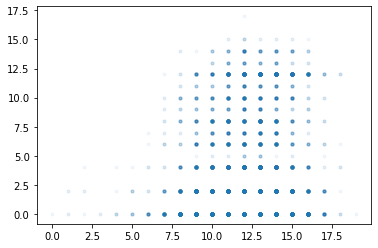

In [7]:
#g = sns.jointplot(
#    x=run["rna_distance"],
#    y=run["struct_distance"],
#    kind="kde",
#)
#g.set_axis_labels('Sec. struc. Levenshtein Distance', 'Nucleotide Levenshtein Distance', fontsize=16)
plt.plot(run["rna_distance"],run["struct_distance"],".",alpha=0.05)

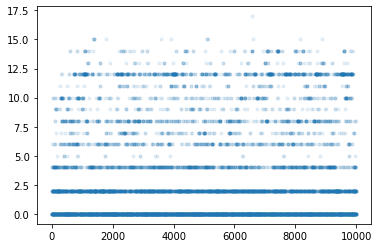

In [8]:
plt.plot(run["struct_distance"],".",alpha=0.1)

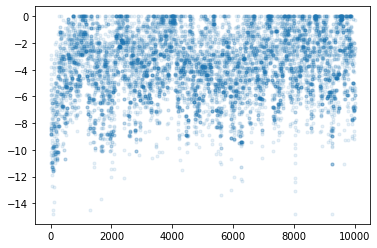

In [9]:
plt.plot(run["mfes"],".",alpha=0.1)

/Users/sergiopeignier/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


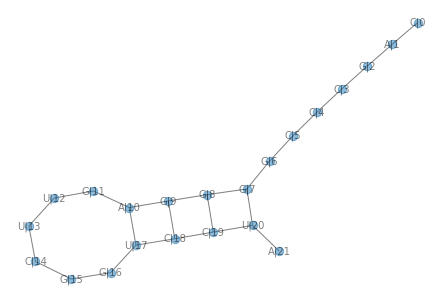

In [10]:
plot_secondary_structure(rnasecstruc_2_graph(run.loc[100,"rna"], run.loc[100,"struct"]))

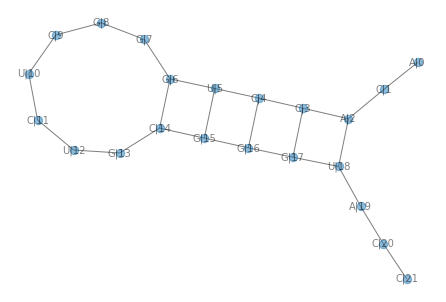

In [11]:
plot_secondary_structure(rnasecstruc_2_graph(run.loc[0,"rna"], run.loc[0,"struct"]))

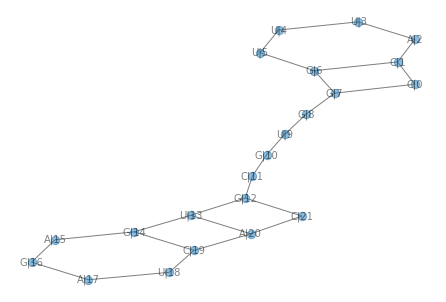

In [12]:
weird = run["struct_distance"].idxmax()
plot_secondary_structure(rnasecstruc_2_graph(run.loc[weird,"rna"], run.loc[weird,"struct"]))

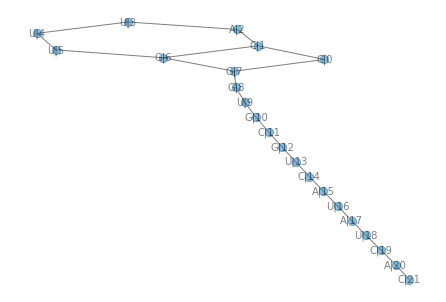

In [13]:
weird = run["struct_distance"].idxmax()
plot_secondary_structure(rnasecstruc_2_graph(run.loc[weird-1,"rna"], run.loc[weird-1,"struct"]))

# Results without neutral network

In [14]:
ancestor_rna = "ACACCUGGGCUCUCCGGGUACC"
neutral_network_from_single,neighborhood_from_single = explore_space(ancestor_rna,
                                                                     100000,
                                                                     allow_neutral_network=False)


In [15]:
neutral_network_from_single.shape

(49764, 6)

In [16]:
neighborhood_from_single.shape

(50237, 6)

(array([ 1590.,     0.,  4435.,  4540., 31654.,     0.,  1498.,     0.,
            0.,  6047.]),
 array([-10.60000038, -10.09000034,  -9.58000031,  -9.07000027,
         -8.56000023,  -8.05000019,  -7.54000015,  -7.03000011,
         -6.52000008,  -6.01000004,  -5.5       ]),
 <a list of 10 Patch objects>)

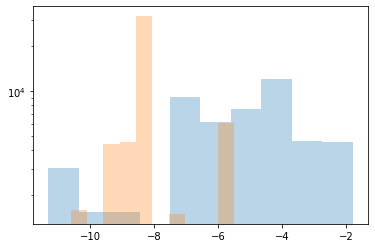

In [17]:
plt.hist(neighborhood_from_single["mfes"],alpha=0.3,log=True)
plt.hist(neutral_network_from_single["mfes"],alpha=0.3,log=True)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9763e+04]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

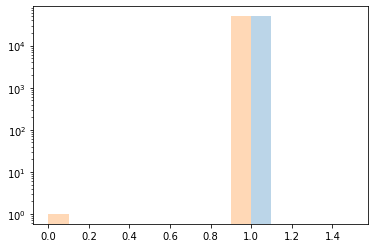

In [18]:
plt.hist(neighborhood_from_single["rna_distance"],alpha=0.3,log=True)
plt.hist(neutral_network_from_single["rna_distance"],alpha=0.3,log=True)


(array([33551.,     0.,     0., 13660.,     0.,     0.,  1512.,     0.,
            0.,  1514.]),
 array([2. , 2.6, 3.2, 3.8, 4.4, 5. , 5.6, 6.2, 6.8, 7.4, 8. ]),
 <a list of 10 Patch objects>)

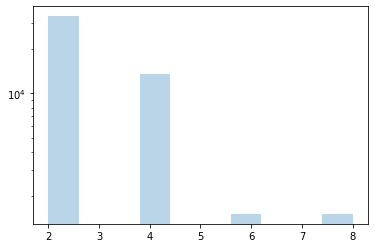

In [19]:
plt.hist(neighborhood_from_single["struct_distance"],alpha=0.3,log=True)

In [20]:
neighborhood_from_single.groupby("struct").count()["generations"].sort_values()

struct
..((((.(.....).))))...    1504
....((.((....)).))....    1512
((((..((.....))))))...    1514
......((((((...)))))).    1514
..(((.(((....))))))...    1537
....(((((....)))))....    1580
...(((.((....)).)))...    2954
..((((.((....))))))...    2968
((.(((((....)))))))...    3038
.(((((((.....)))))))..    3061
..(((((((...)))))))...    3069
..(((.((.....)).)))...    3072
....((((.....)))).....    4574
..((.(((.....))).))...    4592
..(((((.......)))))...    6117
...(((((.....)))))....    7631
Name: generations, dtype: int64

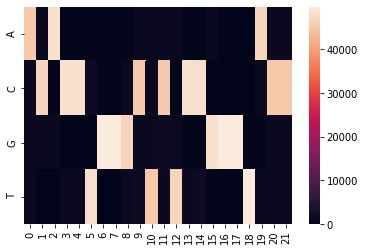

In [21]:
from Bio.Seq import Seq
from Bio import motifs
instances = [Seq("T".join(rna.split("U"))) for rna in neutral_network_from_single["rna"]]
m = motifs.create(instances)
sns.heatmap(pd.DataFrame(m.counts).T)
#m.weblogo("neighborhood_single.png")

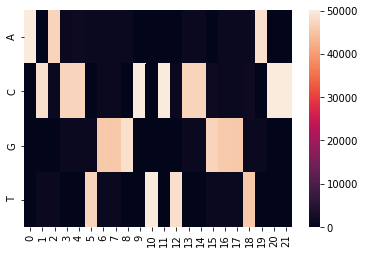

In [22]:
from Bio.Seq import Seq
from Bio import motifs
instances = [Seq("T".join(rna.split("U"))) for rna in neighborhood_from_single["rna"]]
m = motifs.create(instances)
sns.heatmap(pd.DataFrame(m.counts).T)
#m.weblogo("neighborhood_single.png")

# Explore the neutral network

In [23]:
ancestor_rna = "ACACCUGGGCUCUCCGGGUACC"
neutral_network,neighborhood = explore_space(ancestor_rna,100000,allow_neutral_network=True)


In [24]:
neutral_network.shape

(45407, 6)

In [25]:
neighborhood.shape

(54594, 6)

(array([  49.,  280.,  793., 2085., 4385., 8103., 9743., 9591., 7509.,
        2869.]),
 array([-14.  , -12.61, -11.22,  -9.83,  -8.44,  -7.05,  -5.66,  -4.27,
         -2.88,  -1.49,  -0.1 ]),
 <a list of 10 Patch objects>)

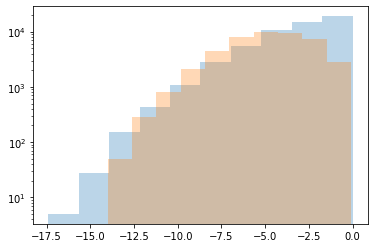

In [26]:
plt.hist(neighborhood["mfes"],alpha=0.3,log=True)
plt.hist(neutral_network["mfes"],alpha=0.3,log=True)

(array([2.0000e+00, 2.0000e+00, 6.4000e+01, 7.9300e+02, 4.7380e+03,
        1.2783e+04, 1.5992e+04, 9.0340e+03, 1.9320e+03, 6.7000e+01]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

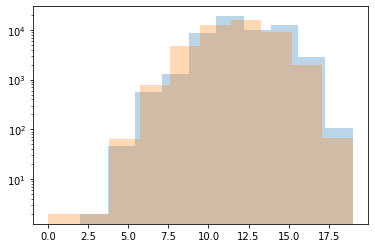

In [27]:
plt.hist(neighborhood["rna_distance"],alpha=0.3,log=True)
plt.hist(neutral_network["rna_distance"],alpha=0.3,log=True)


(array([23174.,  8364.,   139.,  5029.,  4348.,  1711.,  3292.,  6730.,
          707.,  1100.]),
 array([ 2. ,  3.3,  4.6,  5.9,  7.2,  8.5,  9.8, 11.1, 12.4, 13.7, 15. ]),
 <a list of 10 Patch objects>)

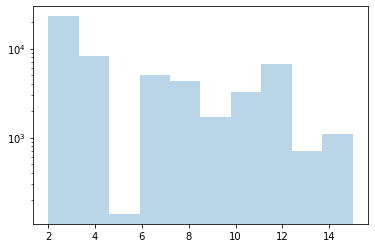

In [28]:
plt.hist(neighborhood["struct_distance"],alpha=0.3,log=True)

In [29]:
neighborhood.groupby("struct").count()["mfes"].sort_values()

struct
((((((((....)))))..)))       1
...(((..((...))..)))..       1
...(((..((....))...)))       1
.(((((.(......).).))))       1
...(((..((.....)).))).       1
                          ... 
.(((((((.....)))))))..    2917
..(((((((...)))))))...    3482
...(((((.....)))))....    4125
..(((((.......)))))...    4870
......................    5571
Name: mfes, Length: 1237, dtype: int64

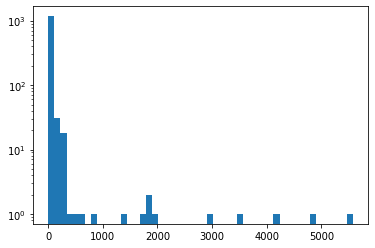

In [30]:
_=plt.hist(neighborhood.groupby("struct").count()["mfes"].sort_values(),log=True, bins=50)

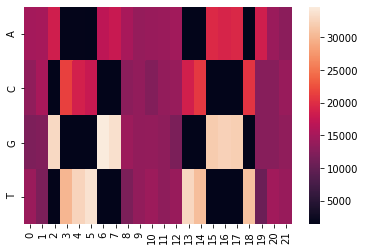

In [31]:
from Bio.Seq import Seq
from Bio import motifs
instances = [Seq("T".join(rna.split("U"))) for rna in neighborhood["rna"]]
m = motifs.create(instances)
sns.heatmap(pd.DataFrame(m.counts).T)
#m.weblogo("neighborhood_single.png")

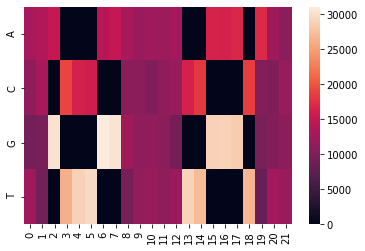

In [32]:
from Bio.Seq import Seq
from Bio import motifs
instances = [Seq("T".join(rna.split("U"))) for rna in neutral_network["rna"]]
m = motifs.create(instances)
sns.heatmap(pd.DataFrame(m.counts).T)
#m.weblogo("neutral_network_single.png")